<h1> Modelagem e implementação do algoritmo

<h3>Imports

In [53]:
import pandas as pd
import pybamm as pb
import numpy as np
import matplotlib.pyplot as plt

<h3>Carregando os dados provenientes do TCC do Vinicius

In [2]:
data_path = '..\data\dados_trajeto.csv'

In [3]:
df = pd.read_csv(data_path, sep = ';')

In [4]:
df.head()

,tempo_s,distancia_m
0,10,155.42
1,11,167.37
2,12,179.33
3,13,191.28
4,14,203.24


In [5]:
df['tempo_s'] = df['tempo_s'] - 10
df['distancia_m'] = df['distancia_m'] - 155.42

df.head()

,tempo_s,distancia_m
0,0,0.00
1,1,11.95
2,2,23.91
3,3,35.86
4,4,47.82


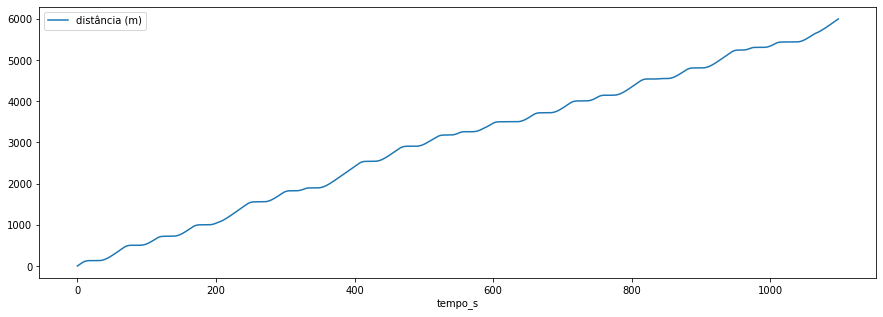

In [6]:
temp = pd.Series(data=df['distancia_m'].values, 
                 index=df['tempo_s'])

temp.plot(figsize=(15, 5), label="distância (m)", legend=True)

plt.show()

In [7]:
delta = df.diff()
delta

,tempo_s,distancia_m
0,NaN,NaN
1,1.0,11.95
2,1.0,11.96
3,1.0,11.95
4,1.0,11.96
...,...,...
1094,1.0,11.87
1095,1.0,11.89
1096,1.0,11.89
1097,1.0,11.91


In [8]:
df['velocidade'] = delta['distancia_m']/delta['tempo_s']

In [9]:
df.fillna(0, inplace=True)
df.head()

,tempo_s,distancia_m,velocidade
0,0,0.00,0.00
1,1,11.95,11.95
2,2,23.91,11.96
3,3,35.86,11.95
4,4,47.82,11.96


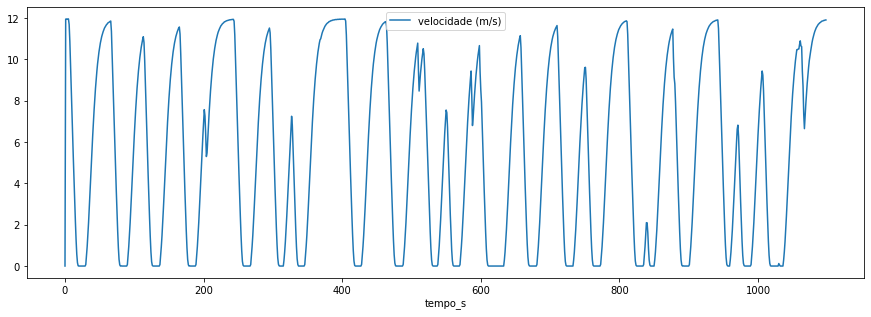

In [10]:
temp = pd.Series(data=df['velocidade'].values, 
                 index=df['tempo_s'])

temp.plot(figsize=(15, 5), label="velocidade (m/s)", legend=True)

plt.show()

<h3>Modelando a demanda de potência do veículo

**Força de arrasto (Fa)**

Fa(t) = 0,5.ρ.Cd.Af.(v(t))²

em que:
* ρ é a densidade do ar
* Cd é o coeficiente de arrasto para o ônibus
* Af é a área da superfície frontal do veículo
* v(t) é a velocidade do veículo em função do tempo


*(Para fins de facilitar os cálculos nesta primeira fase de implementação, será considerado uma inclinação de **0 graus** no trajeto)*

**Força de resistência ao rolamento (Fr)**

Fr(t) = m.g.Cr.cos(§(t))

em que:
* m é a massa do veículo
* g é a aceleração da gravidade (9,81 m/s²)
* Cr é o coeficiente de atrito de rolamento
* §(t) é a inclinação do trajeto em função do tempo

**Força gravitacional (Fg)**

Fg(t) = m.g.Cr.sin(§(t))
(Será nula uma vez que foi considerado um angulo de inclinação de 0 graus)

**Força de aceleração (Facc)**

Facc(t) = m.(dvc(t)/dt)


A Força de tração é a soma de todas as forças citadas acima:

Ftr(t) = Facc(t) + Fg(t) + Fr(t) + Fa(t)

Assim, a demanda de potência pode ser dada por:

Ptr(t) = Ftr(t).v(t)

#### Parâmetros:
    
Cd = 0,36 -> Modelo de ônibus com os cantos da face arredondados Hucho (1986) <br>
ρ = 1,2754 kg/m³ <br>
Fr = 0,9 -> [fonte](https://www.if.ufrgs.br/~lang/Textos/Pneus.pdf) <br>
Af = 2,4x,2,7 = 6,48m² -> [fonte](https://www.ehow.com.br/tamanho-padrao-onibus-urbano-fatos_71396/) <br>
m = 12000 kg -> peso média de um ônibus médio -> [fonte](https://www.diariodasleis.com.br/legislacao/federal/61150-aprova-as-especificacoes-tecnicas-de-veiculos-automotores-de-transporte-coletivo-de-passageiros-rodoviario-e-urbano-intermunicipal.html#:~:text=%C3%94nibus%20leve%3A%20aquele%20com%20peso,ou%20superior%20a%2014%2C0t.) <br>

In [11]:
delta = df.diff()
df['acc'] = abs(delta['velocidade'])/delta['tempo_s']
df.fillna(0, inplace=True)
df.head()

,tempo_s,distancia_m,velocidade,acc
0,0,0.00,0.00,0.00
1,1,11.95,11.95,11.95
2,2,23.91,11.96,0.01
3,3,35.86,11.95,0.01
4,4,47.82,11.96,0.01


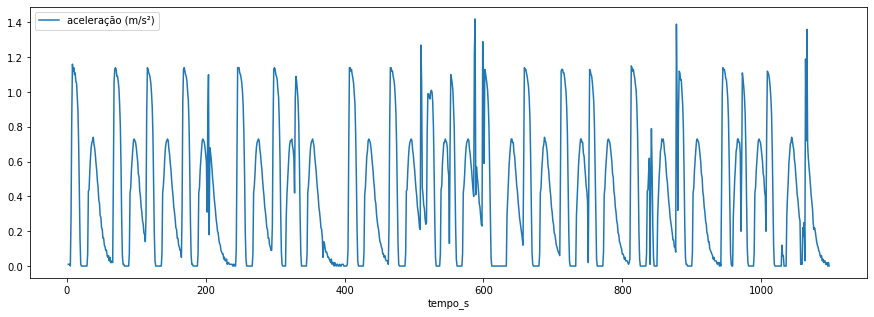

In [12]:
temp = pd.Series(data=df['acc'][2:].values, 
                 index=df['tempo_s'][2:])

temp.plot(figsize=(15, 5), label="aceleração (m/s²)", legend=True)

plt.show()

In [13]:
m = 12000
rho = 1.2754
Cd = 0.36
Cr = 0.9
Af = 6.48
g = 9.81

In [14]:
df['Fa'] = 0.5*rho*Cd*Af*((df['velocidade'])**2)
df['Fr'] = m*g*Cr
df['Facc'] = m*df['acc']
df['Ftr'] = df['Fa'] + df['Fr'] + df['Facc']
df['pot'] = (df['Ftr']*df['velocidade'])/1000

In [15]:
df

,tempo_s,distancia_m,velocidade,acc,Fa,Fr,Facc,Ftr,pot
0,0,0.00,0.00,0.000000e+00,0.000000,105948.0,0.000000e+00,105948.000000,0.000000
1,1,11.95,11.95,1.195000e+01,212.436792,105948.0,1.434000e+05,249560.436792,2982.247220
2,2,23.91,11.96,1.000000e-02,212.792483,105948.0,1.200000e+02,106280.792483,1271.118278
3,3,35.86,11.95,1.000000e-02,212.436792,105948.0,1.200000e+02,106280.436792,1270.051220
4,4,47.82,11.96,1.000000e-02,212.792483,105948.0,1.200000e+02,106280.792483,1271.118278
...,...,...,...,...,...,...,...,...,...
1094,1094,5946.14,11.87,1.000000e-02,209.601971,105948.0,1.200000e+02,106277.601971,1261.515135
1095,1095,5958.03,11.89,2.000000e-02,210.308891,105948.0,2.400000e+02,106398.308891,1265.075893
1096,1096,5969.92,11.89,9.094947e-13,210.308891,105948.0,1.091394e-08,106158.308891,1262.222293
1097,1097,5981.83,11.91,2.000000e-02,211.017001,105948.0,2.400000e+02,106399.017001,1267.212292


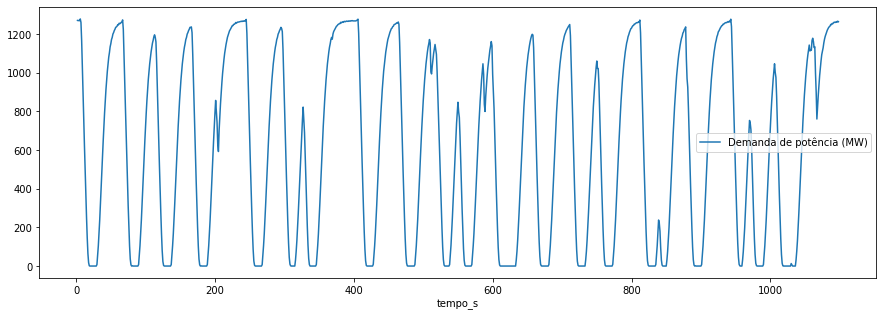

In [16]:
temp = pd.Series(data=df['pot'][2:].values, 
                 index=df['tempo_s'][2:])

temp.plot(figsize=(15, 5), label="Demanda de potência (MW)", legend=True)

plt.show()

In [17]:
bat_model = pb.lithium_ion.DFN()
sim = pb.Simulation(bat_model)

In [19]:
sim.solve([0, df.shape[0]])

In [21]:
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1099.0, step=10.99), Output()), _dom_classes…

In [22]:
bat_model.variable_names()

['Time',
 'Time [s]',
 'Time [min]',
 'Time [h]',
 'x',
 'x [m]',
 'x_n',
 'x_n [m]',
 'x_s',
 'x_s [m]',
 'x_p',
 'x_p [m]',
 'Sum of electrolyte reaction source terms',
 'Sum of positive electrode electrolyte reaction source terms',
 'Sum of x-averaged positive electrode electrolyte reaction source terms',
 'Sum of interfacial current densities',
 'Sum of positive electrode interfacial current densities',
 'Sum of x-averaged positive electrode interfacial current densities',
 'Sum of negative electrode electrolyte reaction source terms',
 'Sum of x-averaged negative electrode electrolyte reaction source terms',
 'Sum of negative electrode interfacial current densities',
 'Sum of x-averaged negative electrode interfacial current densities',
 'r_p',
 'r_p [m]',
 'r_n',
 'r_n [m]',
 'Current density variable',
 'Total current density',
 'Total current density [A.m-2]',
 'Current [A]',
 'C-rate',
 'Discharge capacity [A.h]',
 'Porosity',
 'Separator porosity',
 'Positive electrode porosi

In [28]:
bat_model.variables.search('SOC')

Negative electrode SOC
Positive electrode SOC


In [32]:
bat_model.variables.search('discharge')

Discharge capacity [A.h]


In [37]:
bat_model.variables.search('[A]')

Current [A]


In [58]:
bat_model.variables.search('temperature')

Ambient temperature
Ambient temperature [K]
Cell temperature
Cell temperature [K]
Negative current collector temperature
Negative current collector temperature [K]
Negative electrode temperature
Negative electrode temperature [K]
Positive current collector temperature
Positive current collector temperature [K]
Positive electrode temperature
Positive electrode temperature [K]
Separator temperature
Separator temperature [K]
Volume-averaged cell temperature
Volume-averaged cell temperature [K]
X-averaged cell temperature
X-averaged cell temperature [K]
X-averaged negative electrode temperature
X-averaged negative electrode temperature [K]
X-averaged positive electrode temperature
X-averaged positive electrode temperature [K]
X-averaged separator temperature
X-averaged separator temperature [K]


In [35]:
bat_model.variables.search('voltage')

Battery voltage [V]
Change in measured open circuit voltage
Change in measured open circuit voltage [V]
Local voltage
Local voltage [V]
Measured battery open circuit voltage [V]
Measured open circuit voltage
Measured open circuit voltage [V]
Terminal voltage
Terminal voltage [V]
X-averaged battery open circuit voltage [V]
X-averaged open circuit voltage
X-averaged open circuit voltage [V]


In [40]:
vals = ['Battery voltage [V]',
          'Measured battery open circuit voltage [V]',
          'Terminal voltage [V]',
          'Discharge capacity [A.h]',
          'Negative electrode SOC',
          'Positive electrode SOC',
          'Current [A]']

sim.plot(vals);

interactive(children=(FloatSlider(value=0.0, description='t', max=1099.0, step=10.99), Output()), _dom_classes…

In [54]:
bat_vol = sim.solution[vals[0]]
bat_vol(t=np.arange(0, df.shape[0]+1, 1, dtype=int))

array([3.77161552, 3.77088642, 3.77015732, ..., 3.65834688, 3.65828793,
       3.65822898])

In [52]:
bat_vol.data

array([3.77161552, 3.76352177, 3.75913196, 3.75584548, 3.75320357,
       3.750975  , 3.74902141, 3.74725588, 3.74562134, 3.7440805 ,
       3.74260764, 3.74118556, 3.73980237, 3.73844974, 3.73712186,
       3.73581449, 3.73452487, 3.73325049, 3.73199008, 3.73074227,
       3.72950642, 3.72828183, 3.7270681 , 3.72586494, 3.72467216,
       3.72348961, 3.72231715, 3.72115469, 3.72000218, 3.71885957,
       3.71772694, 3.71660423, 3.71549139, 3.71438853, 3.7132954 ,
       3.71221206, 3.71113878, 3.71007513, 3.70902112, 3.7079767 ,
       3.70694181, 3.70591637, 3.70489997, 3.70389273, 3.70289431,
       3.70190454, 3.70092315, 3.69994989, 3.69898446, 3.69802661,
       3.69707606, 3.69613255, 3.69519585, 3.69426577, 3.69334216,
       3.6924249 , 3.69151397, 3.69060919, 3.68971053, 3.68881811,
       3.68793196, 3.68705215, 3.68617857, 3.68531131, 3.6844504 ,
       3.68359589, 3.68274779, 3.68190613, 3.68107092, 3.6802422 ,
       3.67941997, 3.67860419, 3.67779487, 3.67699201, 3.67619

In [55]:
df['Battery voltage [V]'] = pd.Series(bat_vol(t=np.arange(0, df.shape[0]+1, 1, dtype=int)))

In [56]:
df

,tempo_s,distancia_m,velocidade,acc,Fa,Fr,Facc,Ftr,pot,Battery voltage [V]
0,0,0.00,0.00,0.000000e+00,0.000000,105948.0,0.000000e+00,105948.000000,0.000000,3.771616
1,1,11.95,11.95,1.195000e+01,212.436792,105948.0,1.434000e+05,249560.436792,2982.247220,3.770886
2,2,23.91,11.96,1.000000e-02,212.792483,105948.0,1.200000e+02,106280.792483,1271.118278,3.770157
3,3,35.86,11.95,1.000000e-02,212.436792,105948.0,1.200000e+02,106280.436792,1270.051220,3.769428
4,4,47.82,11.96,1.000000e-02,212.792483,105948.0,1.200000e+02,106280.792483,1271.118278,3.768699
...,...,...,...,...,...,...,...,...,...,...
1094,1094,5946.14,11.87,1.000000e-02,209.601971,105948.0,1.200000e+02,106277.601971,1261.515135,3.658524
1095,1095,5958.03,11.89,2.000000e-02,210.308891,105948.0,2.400000e+02,106398.308891,1265.075893,3.658465
1096,1096,5969.92,11.89,9.094947e-13,210.308891,105948.0,1.091394e-08,106158.308891,1262.222293,3.658406
1097,1097,5981.83,11.91,2.000000e-02,211.017001,105948.0,2.400000e+02,106399.017001,1267.212292,3.658347
